## 1. Import necessary libraries


In [70]:
import sklearn
import re
import spacy
import string
import nltk
import gensim
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from collections import Counter
from textblob import TextBlob
from heapq import nlargest
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from tidytext import unnest_tokens
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import bigrams
from nltk.corpus import stopwords,opinion_lexicon
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.probability import FreqDist

from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary


## 1.1 Data Collection

### Import the datasets

In [71]:
Rick_mont = pd.read_csv("H:\BSSc\Sem 7\Text Analytics\Ass 1\RickAndMortyScripts.csv")
#Rick_mont = Rick_mont[['name', 'line']]
Rick_mont["line"] = Rick_mont["line"].astype(str)
Rick_mont.head()

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Just... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


## 1.2 Data Exploration



### Find the missing values

In [72]:
Rick_mont.isna().sum()

index           0
season no.      0
episode no.     0
episode name    0
name            0
line            0
dtype: int64

### Remove unwanted colunms

In [73]:
Rick_mont = Rick_mont[['name', 'line']]
Rick_mont

,name,line
0,Rick,Morty! You gotta come on. Just... you gotta co...
1,Morty,"What, Rick? What’s going on?"
2,Rick,"I got a surprise for you, Morty."
3,Morty,It's the middle of the night. What are you tal...
4,Rick,"Come on, I got a surprise for you. Come on, h..."
...,...,...
1900,Morty,That was amazing!
1901,Rick,Got some of that mermaid puss!
1902,Morty,I'm really hoping it wasn't a one-off thing an...
1903,Rick,"Pssh! Not at all, Morty. That place will never..."


### Check the data types

In [74]:
Rick_mont.dtypes


name    object
line    object
dtype: object

## 1.3 Data Preprocessing

### Data Cleaning

* #### Remove Whitespaces

In [75]:
Rick_mont = Rick_mont.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
Rick_mont.head()

,name,line
0,Rick,Morty! You gotta come on. Just... you gotta co...
1,Morty,"What, Rick? What’s going on?"
2,Rick,"I got a surprise for you, Morty."
3,Morty,It's the middle of the night. What are you tal...
4,Rick,"Come on, I got a surprise for you. Come on, h..."


* #### Remove numbers 

In [76]:
Rick_mont = Rick_mont.apply(lambda x: x.str.replace('\d+', '') if x.dtype == "object" else x)

C:\Users\Himasha\AppData\Local\Temp\ipykernel_14800\654601527.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Rick_mont = Rick_mont.apply(lambda x: x.str.replace('\d+', '') if x.dtype == "object" else x)


* #### Expanding Contractions

In [77]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
Rick_mont['line']=Rick_mont['line'].apply(lambda x:expand_contractions(x))
Rick_mont.head()

,name,line
0,Rick,Morty! You gotta come on. Just... you gotta co...
1,Morty,"What, Rick? What’s going on?"
2,Rick,"I got a surprise for you, Morty."
3,Morty,It is the middle of the night. What are you ta...
4,Rick,"Come on, I got a surprise for you. Come on, h..."


* #### Lower Casing

In [78]:
# Convert text to lowercase
Rick_mont['line_lower'] = Rick_mont['line'].str.lower()
Rick_mont.head()

,name,line,line_lower
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?"
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty."
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h..."


* ####  Removal of Punctuations


In [79]:
# Remove special characters and punctuation
Rick_mont['line_wo_spchar'] = Rick_mont['line_lower'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))
Rick_mont.head()

,name,line,line_lower,line_wo_spchar
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...


* #### Removal of stopwords


In [80]:
# Remove stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

Rick_mont["text_wo_stop"] = Rick_mont['line_wo_spchar'].apply(lambda text: remove_stopwords(text))
Rick_mont.head()

,name,line,line_lower,line_wo_spchar,text_wo_stop
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry


* #### Removal of Frequent words

In [81]:
from collections import Counter
cnt = Counter()
for text in Rick_mont["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('morty', 341),
 ('rick', 171),
 ('oh', 171),
 ('know', 168),
 ('get', 139),
 ('gonna', 113),
 ('like', 108),
 ('time', 89),
 ('right', 88),
 ('go', 81)]

In [82]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent word"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

Rick_mont["line_wo_stopfreq"] = Rick_mont["text_wo_stop"].apply(lambda text: remove_freqwords(text))
Rick_mont.head()

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry


* #### Removal of Rare words


In [83]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

Rick_mont["line_wo_stoprare"] = Rick_mont["line_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
Rick_mont.head()

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq,line_wo_stoprare
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come,gotta come gotta come
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going,whats going
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise,got surprise
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking,middle night talking
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry


### Lemmatization

In [84]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

Rick_mont["text_lemmatized"] = Rick_mont["line_wo_stoprare"].apply(lambda text: lemmatize_words(text))
Rick_mont.head()

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq,line_wo_stoprare,text_lemmatized
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come,gotta come gotta come,gotta come gotta come
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going,whats going,whats going
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise,got surprise,got surprise
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking,middle night talking,middle night talking
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry


## 1.4. Data Analysis

### Sentiment Analysis

In [85]:
# Define a function to get the sentiment of a sentence
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the function to the dataframe
Rick_mont['Sentiment'] = Rick_mont['text_lemmatized'].apply(get_sentiment)
Rick_mont

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq,line_wo_stoprare,text_lemmatized,Sentiment
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come,gotta come gotta come,gotta come gotta come,0.0
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going,whats going,whats going,0.0
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise,got surprise,got surprise,0.0
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking,middle night talking,middle night talking,0.0
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,0.0
...,...,...,...,...,...,...,...,...,...
1900,Morty,That was amazing!,that was amazing!,that was amazing,amazing,amazing,amazing,amazing,0.6
1901,Rick,Got some of that mermaid puss!,got some of that mermaid puss!,got some of that mermaid puss,got mermaid puss,got mermaid puss,got mermaid puss,got mermaid pus,0.0
1902,Morty,I am really hoping it was not a one-off thing ...,i am really hoping it was not a one-off thing ...,i am really hoping it was not a oneoff thing a...,really hoping oneoff thing see way hey um stil...,really hoping oneoff thing see way hey um stil...,really hoping thing see way hey um still might...,really hoping thing see way hey um still might...,-0.2
1903,Rick,"Pssh! Not at all, Morty. That place will never...","pssh! not at all, morty. that place will never...",pssh not at all morty that place will never ha...,pssh morty place never bearing lives ever unli...,pssh place never bearing lives ever unlike mer...,place never lives ever mermaid puss yeah going...,place never life ever mermaid pus yeah going b...,-0.1


#### Build a model to predict the emotions

In [86]:
model_name = "cardiffnlp/twitter-roberta-base-emoji"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [87]:
def predict_emotions(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors="pt")
    
    # Predict the emotions
    outputs = model(**inputs)
    scores = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]
    
    # Map the emotion scores to their corresponding labels
    labels = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]
    results = dict(zip(labels, scores))
    
    return results

In [88]:
sentiments = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]
for sentiment in sentiments:
    Rick_mont[sentiment] = Rick_mont["text_lemmatized"].apply(lambda x: predict_emotions(x)[sentiment])
Rick_mont.head()

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq,line_wo_stoprare,text_lemmatized,Sentiment,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come,gotta come gotta come,gotta come gotta come,0.0,0.191261,0.042400,0.036680,0.031107,0.085944,0.024291,0.062019,0.131736
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going,whats going,whats going,0.0,0.010141,0.051306,0.255786,0.010963,0.159835,0.022899,0.174792,0.031008
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise,got surprise,got surprise,0.0,0.042239,0.128516,0.135711,0.026835,0.045547,0.092153,0.064295,0.064623
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking,middle night talking,middle night talking,0.0,0.103193,0.041361,0.115460,0.124614,0.014548,0.150087,0.058137,0.074654
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,0.0,0.047278,0.179006,0.083852,0.021701,0.177497,0.059280,0.076175,0.056676


In [89]:
def get_sentiment_category(score):
    if score > 0.5:
        return "positive"
    elif score > 0:
        return "anticipation"
    elif score == 0:
        return "neutral"
    elif score > -0.5:
        return "sadness"
    else:
        return "negative"

Rick_mont["Sentiment Category"] = Rick_mont['Sentiment'].apply(get_sentiment_category)

In [90]:
sentiment_counts = Rick_mont["Sentiment Category"].value_counts()

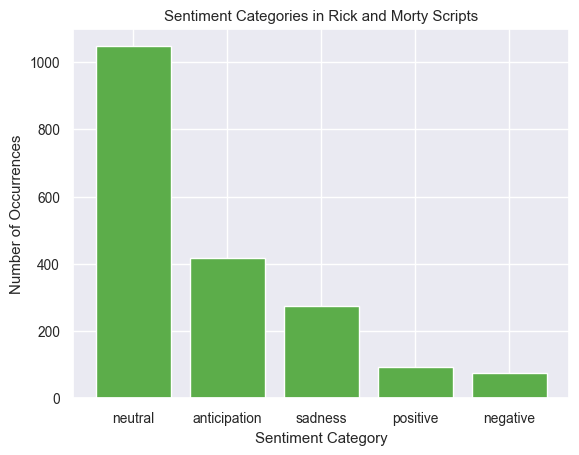

In [91]:
plt.bar(sentiment_counts.index, sentiment_counts.values, color='#5CAD4A')
plt.title("Sentiment Categories in Rick and Morty Scripts")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Occurrences")
plt.show()

### Topic Modeling

In [92]:
# Tokenize the text data
data = [simple_preprocess(text) for text in Rick_mont["text_lemmatized"]]

# Create a dictionary from the data
dictionary = Dictionary(data)

# Convert the data into a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in data]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# Print the topics and their top words
for topic_id, topic in lda_model.print_topics(num_topics=10):
    print(f"Topic {topic_id}: {topic}")

Topic 0: 0.011*"uh" + 0.011*"got" + 0.011*"one" + 0.009*"yeah" + 0.009*"would" + 0.008*"mean" + 0.008*"hey" + 0.008*"thing" + 0.008*"man" + 0.007*"think"
Topic 1: 0.012*"got" + 0.007*"come" + 0.007*"whole" + 0.007*"could" + 0.006*"think" + 0.006*"want" + 0.006*"look" + 0.005*"gotta" + 0.005*"ii" + 0.005*"dream"
Topic 2: 0.018*"think" + 0.015*"whoa" + 0.009*"say" + 0.009*"well" + 0.009*"okay" + 0.007*"never" + 0.007*"make" + 0.007*"really" + 0.006*"want" + 0.006*"would"
Topic 3: 0.012*"mean" + 0.011*"dont" + 0.009*"well" + 0.008*"talking" + 0.008*"see" + 0.008*"going" + 0.006*"work" + 0.006*"let" + 0.006*"youre" + 0.006*"make"
Topic 4: 0.011*"jerry" + 0.008*"well" + 0.008*"really" + 0.008*"fine" + 0.008*"man" + 0.008*"wait" + 0.007*"grandpa" + 0.007*"head" + 0.007*"let" + 0.007*"youre"
Topic 5: 0.009*"come" + 0.009*"take" + 0.008*"summer" + 0.008*"one" + 0.008*"youre" + 0.008*"got" + 0.007*"need" + 0.006*"could" + 0.006*"say" + 0.006*"guy"
Topic 6: 0.018*"yeah" + 0.013*"take" + 0.009*"t

### Named Entity Recognition

* #### Tokenization

In [93]:
# Tokenize the text into individual words
Rick_mont['Tokenize'] = Rick_mont['text_lemmatized'].apply(lambda x: nltk.word_tokenize(x))
Rick_mont.head()

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq,line_wo_stoprare,text_lemmatized,Sentiment,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,Sentiment Category,Tokenize
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come,gotta come gotta come,gotta come gotta come,0.0,0.191261,0.042400,0.036680,0.031107,0.085944,0.024291,0.062019,0.131736,neutral,"[got, ta, come, got, ta, come]"
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going,whats going,whats going,0.0,0.010141,0.051306,0.255786,0.010963,0.159835,0.022899,0.174792,0.031008,neutral,"[whats, going]"
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise,got surprise,got surprise,0.0,0.042239,0.128516,0.135711,0.026835,0.045547,0.092153,0.064295,0.064623,neutral,"[got, surprise]"
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking,middle night talking,middle night talking,0.0,0.103193,0.041361,0.115460,0.124614,0.014548,0.150087,0.058137,0.074654,neutral,"[middle, night, talking]"
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,0.0,0.047278,0.179006,0.083852,0.021701,0.177497,0.059280,0.076175,0.056676,neutral,"[come, got, surprise, come, hurry]"


* #### Tag the words

In [94]:
Rick_mont['tagged'] = Rick_mont['Tokenize'].apply(nltk.pos_tag)

In [95]:
Rick_mont[['tagged']].head()

,tagged
0,"[(got, VBD), (ta, JJ), (come, VBN), (got, VBD)..."
1,"[(whats, NNS), (going, VBG)]"
2,"[(got, VBD), (surprise, NN)]"
3,"[(middle, JJ), (night, NN), (talking, VBG)]"
4,"[(come, VBN), (got, VBD), (surprise, JJ), (com..."


* #### Identify the Nouns

In [96]:
Rick_mont['nouns'] = Rick_mont['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [97]:
Rick_mont[['line', 'nouns']].head()

,line,nouns
0,Morty! You gotta come on. Just... you gotta co...,[come]
1,"What, Rick? What’s going on?",[whats]
2,"I got a surprise for you, Morty.",[surprise]
3,It is the middle of the night. What are you ta...,[night]
4,"Come on, I got a surprise for you. Come on, h...","[come, hurry]"


* #### Identify the Verbs

In [98]:
Rick_mont['verbs'] = Rick_mont['tagged'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBP', 'VBN', 'VBG', 'VBD']])

In [99]:
Rick_mont[['line', 'verbs']].head()

,line,verbs
0,Morty! You gotta come on. Just... you gotta co...,"[got, come, got]"
1,"What, Rick? What’s going on?",[going]
2,"I got a surprise for you, Morty.",[got]
3,It is the middle of the night. What are you ta...,[talking]
4,"Come on, I got a surprise for you. Come on, h...","[come, got]"


* #### Identify the People

In [100]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")


# Define a function to extract named entities
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for entity in doc.ents:
        if entity.label_ == "PERSON":
            entities.append(entity.text)
    return entities

# Apply the function to the "Line" column of the dataset
Rick_mont["People"] = Rick_mont["line"].apply(extract_entities)

# Print the first 10 rows of the dataset with the identified organizations
print(Rick_mont[["line", "People"]].head(10))


                                                line   People
0  Morty! You gotta come on. Just... you gotta co...       []
1                       What, Rick? What’s going on?   [Rick]
2                   I got a surprise for you, Morty.       []
3  It is the middle of the night. What are you ta...       []
4  Come on, I got a surprise for you.  Come on, h...       []
5                Ow! Ow! You're tugging me too hard!       []
6  We gotta go, gotta get outta here, come on. Go...       []
7  What do you think of this... flying vehicle, M...  [Morty]
8  Yeah, Rick... I-it is great. Is this the surpr...   [Rick]
9  Morty. I had to... I had to do it. I had— I ha...  [Morty]


* ####  Identify the Palces

In [101]:
# Define a function to extract named entities
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for entity in doc.ents:
        if entity.label_ == "GPE":
            entities.append(entity.text)
    return entities

# Apply the function to the "Line" column of the dataset
Rick_mont["Places"] = Rick_mont["line"].apply(extract_entities)

# Print the first 10 rows of the dataset with the identified organizations
print(Rick_mont[["line", "Places"]].head(10))


                                                line Places
0  Morty! You gotta come on. Just... you gotta co...     []
1                       What, Rick? What’s going on?     []
2                   I got a surprise for you, Morty.     []
3  It is the middle of the night. What are you ta...     []
4  Come on, I got a surprise for you.  Come on, h...     []
5                Ow! Ow! You're tugging me too hard!     []
6  We gotta go, gotta get outta here, come on. Go...     []
7  What do you think of this... flying vehicle, M...     []
8  Yeah, Rick... I-it is great. Is this the surpr...     []
9  Morty. I had to... I had to do it. I had— I ha...     []


## 1.5. Data Visualization

### Word cloud

* #### The most frequent words in the script

   name                                               line  \
0  Rick  Morty! You gotta come on. Just... you gotta co...   
0  Rick  Morty! You gotta come on. Just... you gotta co...   
0  Rick  Morty! You gotta come on. Just... you gotta co...   
0  Rick  Morty! You gotta come on. Just... you gotta co...   
0  Rick  Morty! You gotta come on. Just... you gotta co...   

                                          line_lower  \
0  morty! you gotta come on. just... you gotta co...   
0  morty! you gotta come on. just... you gotta co...   
0  morty! you gotta come on. just... you gotta co...   
0  morty! you gotta come on. just... you gotta co...   
0  morty! you gotta come on. just... you gotta co...   

                                      line_wo_spchar  \
0  morty you gotta come on just you gotta come wi...   
0  morty you gotta come on just you gotta come wi...   
0  morty you gotta come on just you gotta come wi...   
0  morty you gotta come on just you gotta come wi...   
0  morty y

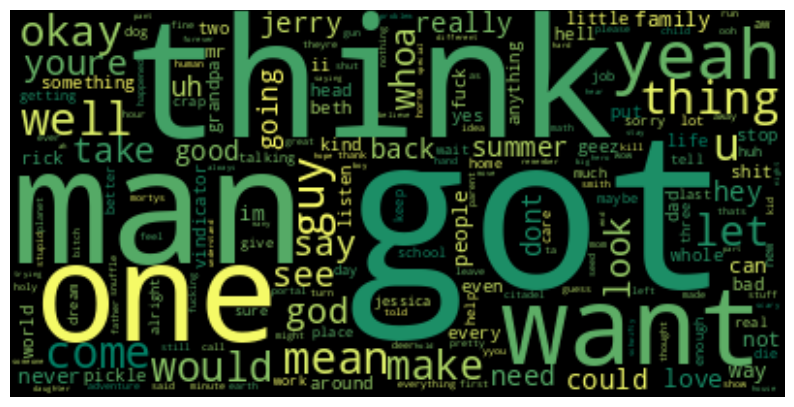

In [102]:
# Tokenize the text using the unnest_tokens function
tokens = unnest_tokens(Rick_mont, input="text_lemmatized", output="word")
# Print the first 5 rows of the resulting dataframe
print(tokens.head(5))
# Create a list of words from the tokens dataframe
words = list(tokens['word'])

# Create a dictionary of word frequencies
freq = dict(tokens.groupby('word')['word'].count())

# Generate the word cloud

wordcloud = WordCloud(background_color='black', random_state=100, max_words=1000, colormap='summer', collocations=False, stopwords = STOPWORDS).generate_from_frequencies(freq)


# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Add the word cloud to the plot
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# Show the plot
plt.show()


* #### An overall glimpse on the positive and negative words in the script.

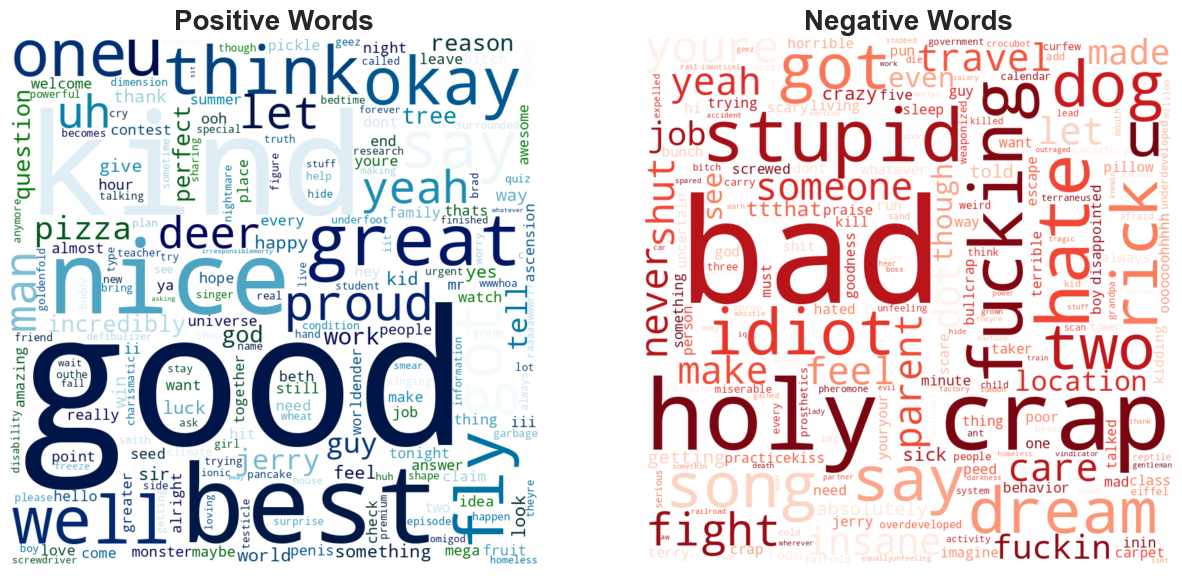

In [103]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Create separate dataframes for positive and negative lines
positive = Rick_mont[Rick_mont['Sentiment'] > 0.5]
negative = Rick_mont[Rick_mont['Sentiment'] < -0.5]

# Get the text for each set of lines
positive_text = ' '.join(positive['text_lemmatized'])
negative_text = ' '.join(negative['text_lemmatized'])

# Create word clouds for positive and negative words
positive_cloud = WordCloud(background_color='white', width=800, height=800, colormap='ocean').generate(positive_text)
negative_cloud = WordCloud(background_color='white', width=800, height=800, colormap='Reds').generate(negative_text)

# Display the word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(positive_cloud, interpolation='bilinear')
ax1.set_title('Positive Words', fontsize=20, fontweight='bold')
ax1.axis('off')
ax2.imshow(negative_cloud, interpolation='bilinear')
ax2.set_title('Negative Words', fontsize=20, fontweight='bold')
ax2.axis('off')
plt.show()

### Bar charts

* #### Most Talkative in Rick & Morty

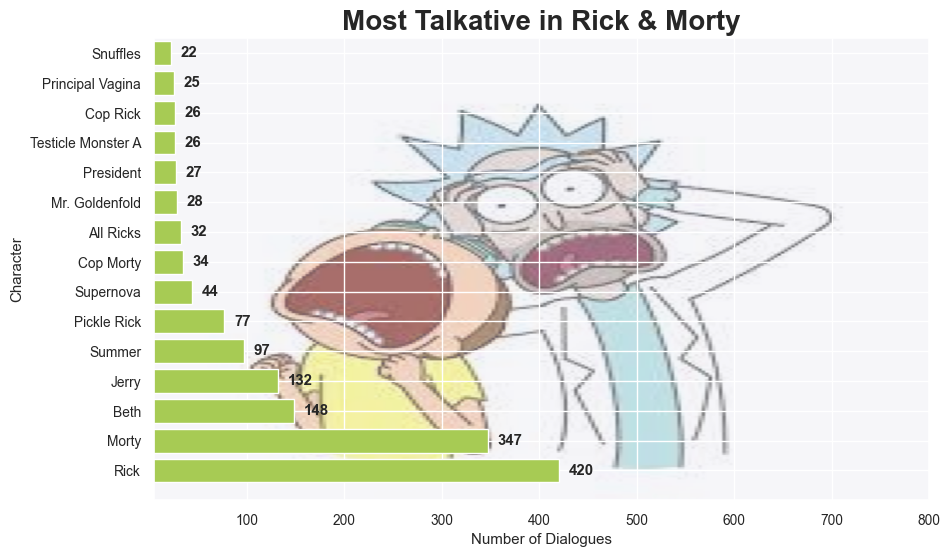

In [104]:
# Prepare the table
top_15 = Rick_mont['name'].value_counts().nlargest(15).reset_index()
top_15.columns = ['name', 'text_lemmatized']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(top_15['name'], top_15['text_lemmatized'], color='#A7CB54')
ax.set_xlabel('Number of Dialogues')
ax.set_ylabel('Character')
ax.set_title('Most Talkative in Rick & Morty',fontsize=20, fontweight='bold')
ax.invert_yaxis()

# Add labels to the bars
for i, (name, text_lemmatized) in enumerate(zip(top_15['name'], top_15['text_lemmatized'])):
    ax.text(text_lemmatized + 10, i, text_lemmatized, ha='left', va='center', fontweight='bold')

# Load the image file
image = Image.open("mostTalk.png")

# Add the image to the plot
ax.imshow(image, extent=[5, 800, -1, 14.5], aspect='auto')

# Show the plot
plt.show()

* #### Mood distribution in Rick and Monty Series

In [105]:
Rick_mont["polarity"] = Rick_mont["text_lemmatized"].apply(lambda x: TextBlob(x).sentiment.polarity)
Rick_mont

,name,line,line_lower,line_wo_spchar,text_wo_stop,line_wo_stopfreq,line_wo_stoprare,text_lemmatized,Sentiment,anger,...,surprise,trust,Sentiment Category,Tokenize,tagged,nouns,verbs,People,Places,polarity
0,Rick,Morty! You gotta come on. Just... you gotta co...,morty! you gotta come on. just... you gotta co...,morty you gotta come on just you gotta come wi...,morty gotta come gotta come,gotta come gotta come,gotta come gotta come,gotta come gotta come,0.0,0.191261,...,0.062019,0.131736,neutral,"[got, ta, come, got, ta, come]","[(got, VBD), (ta, JJ), (come, VBN), (got, VBD)...",[come],"[got, come, got]",[],[],0.0
1,Morty,"What, Rick? What’s going on?","what, rick? what’s going on?",what rick whats going on,rick whats going,whats going,whats going,whats going,0.0,0.010141,...,0.174792,0.031008,neutral,"[whats, going]","[(whats, NNS), (going, VBG)]",[whats],[going],[Rick],[],0.0
2,Rick,"I got a surprise for you, Morty.","i got a surprise for you, morty.",i got a surprise for you morty,got surprise morty,got surprise,got surprise,got surprise,0.0,0.042239,...,0.064295,0.064623,neutral,"[got, surprise]","[(got, VBD), (surprise, NN)]",[surprise],[got],[],[],0.0
3,Morty,It is the middle of the night. What are you ta...,it is the middle of the night. what are you ta...,it is the middle of the night what are you tal...,middle night talking,middle night talking,middle night talking,middle night talking,0.0,0.103193,...,0.058137,0.074654,neutral,"[middle, night, talking]","[(middle, JJ), (night, NN), (talking, VBG)]",[night],[talking],[],[],0.0
4,Rick,"Come on, I got a surprise for you. Come on, h...","come on, i got a surprise for you. come on, h...",come on i got a surprise for you come on hurr...,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,come got surprise come hurry,0.0,0.047278,...,0.076175,0.056676,neutral,"[come, got, surprise, come, hurry]","[(come, VBN), (got, VBD), (surprise, JJ), (com...","[come, hurry]","[come, got]",[],[],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,Morty,That was amazing!,that was amazing!,that was amazing,amazing,amazing,amazing,amazing,0.6,0.033853,...,0.024769,0.272533,positive,[amazing],"[(amazing, VBG)]",[],[amazing],[],[],0.6
1901,Rick,Got some of that mermaid puss!,got some of that mermaid puss!,got some of that mermaid puss,got mermaid puss,got mermaid puss,got mermaid puss,got mermaid pus,0.0,0.044537,...,0.032558,0.275572,neutral,"[got, mermaid, pus]","[(got, VBD), (mermaid, JJ), (pus, NN)]",[pus],[got],[],[],0.0
1902,Morty,I am really hoping it was not a one-off thing ...,i am really hoping it was not a one-off thing ...,i am really hoping it was not a oneoff thing a...,really hoping oneoff thing see way hey um stil...,really hoping oneoff thing see way hey um stil...,really hoping thing see way hey um still might...,really hoping thing see way hey um still might...,-0.2,0.010306,...,0.071703,0.073476,sadness,"[really, hoping, thing, see, way, hey, um, sti...","[(really, RB), (hoping, VBG), (thing, NN), (se...","[thing, way, hey, citadel, place]","[hoping, see, um, happened]",[],[],-0.2
1903,Rick,"Pssh! Not at all, Morty. That place will never...","pssh! not at all, morty. that place will never...",pssh not at all morty that place will never ha...,pssh morty place never bearing lives ever unli...,pssh place never bearing lives ever unlike mer...,place never lives ever mermaid puss yeah going...,place never life ever mermaid pus yeah going b...,-0.1,0.018227,...,0.129737,0.222086,sadness,"[place, never, life, ever, mermaid, pus, yeah,...","[(place, NN), (never, RB), (life, NN), (ever, ...","[place, life, pus, yeah, week, man, atlantis]","[mermaid, going, shit]",[Morty],[],-0.1


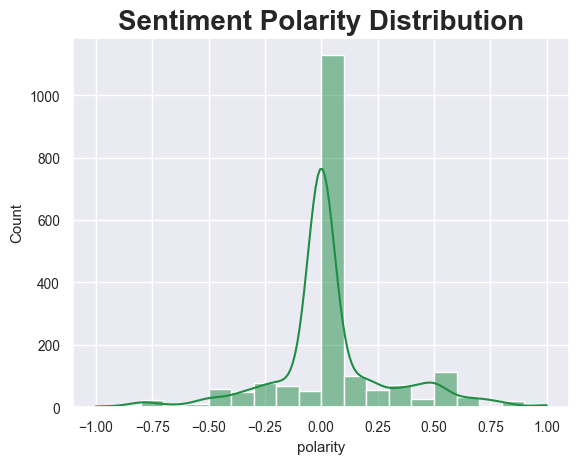

In [106]:
sns.histplot(data=Rick_mont, x="polarity", bins=20, kde=True, color='#208D45')
plt.title("Sentiment Polarity Distribution", fontsize=20, fontweight='bold')
plt.show()

* #### Most frequent words of each character

RICK
[('got', 46), ('come', 28), ('take', 28), ('thing', 28), ('guy', 28), ('yeah', 25), ('want', 24), ('jerry', 22), ('youre', 21), ('mean', 20)]




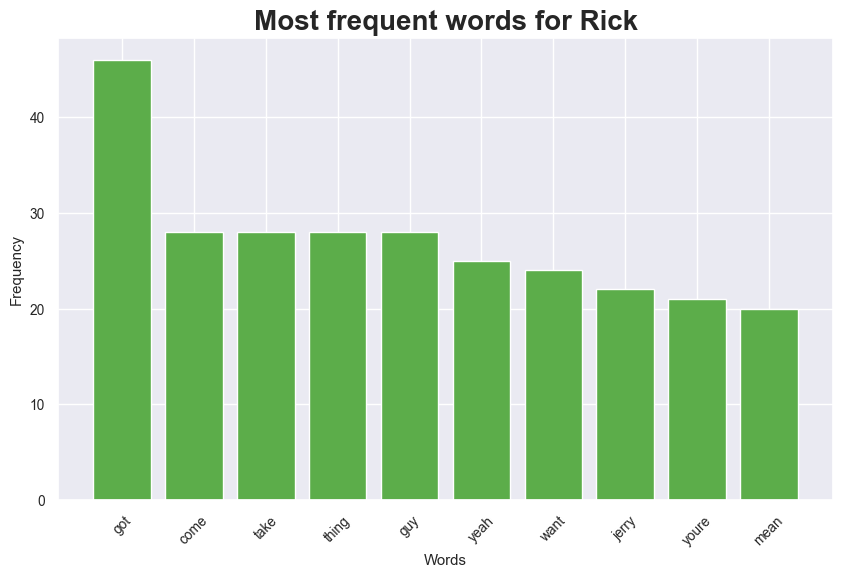

MORTY
[('man', 22), ('thing', 17), ('geez', 16), ('yeah', 15), ('jessica', 15), ('well', 14), ('uh', 13), ('mean', 13), ('summer', 12), ('okay', 11)]




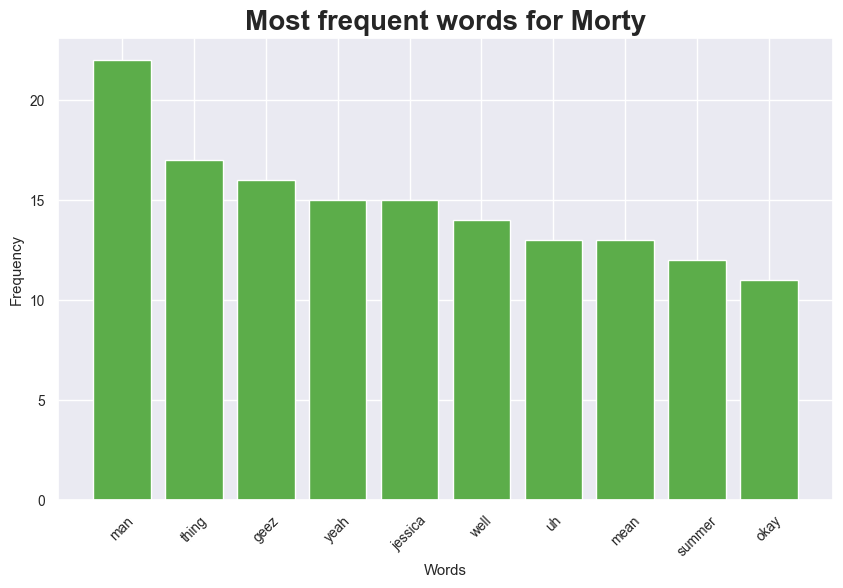

BETH
[('jerry', 23), ('dad', 12), ('summer', 12), ('want', 10), ('mean', 9), ('okay', 8), ('need', 8), ('think', 7), ('u', 7), ('well', 7)]




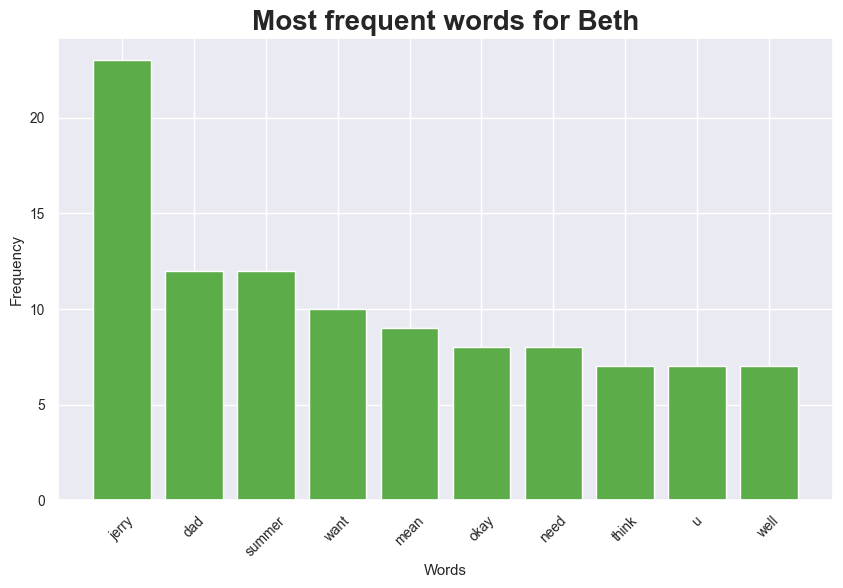

SUMMER
[('god', 13), ('grandpa', 13), ('head', 9), ('going', 6), ('back', 5), ('want', 4), ('let', 4), ('come', 4), ('dad', 4), ('youre', 4)]




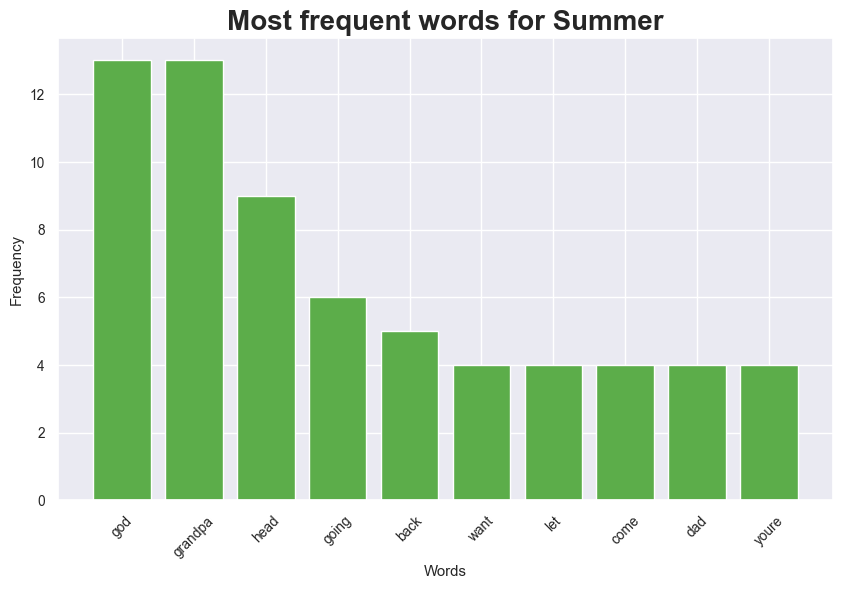

JERRY
[('well', 14), ('beth', 10), ('guy', 9), ('okay', 9), ('yeah', 9), ('got', 9), ('thing', 9), ('think', 7), ('love', 7), ('uh', 7)]




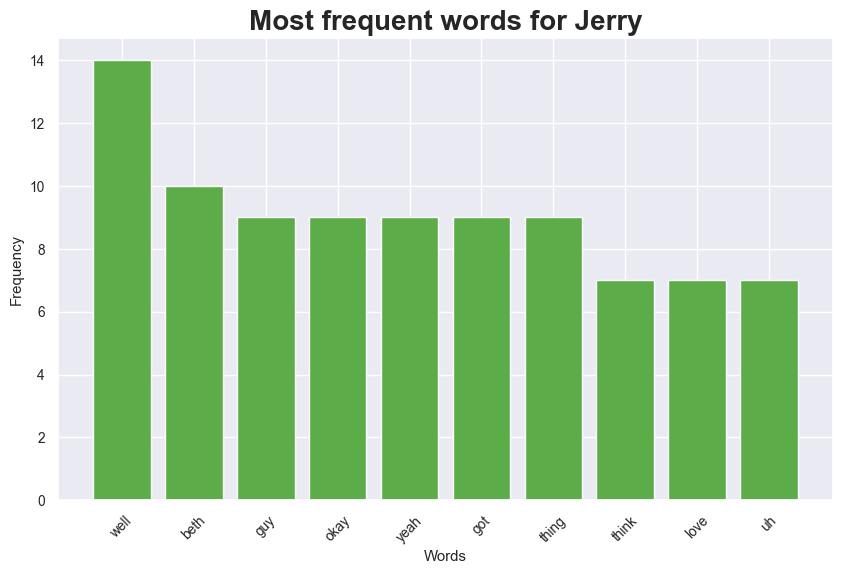

In [107]:
# Define a list of Smith family characters
smiths = ['Rick', 'Morty','Beth', 'Summer','Jerry']

# Loop through each Smith family character
for smith in smiths:
    # Select only the rows for the current Smith family character
    smith_df = Rick_mont[Rick_mont['name'] == smith]
    
    # Combine all the character's lines into a single string
    smith_text = ' '.join(smith_df['text_lemmatized'].tolist())
    
    # Tokenize the text into words
    smith_tokens = word_tokenize(smith_text.lower())
    
    # Remove stopwords and non-alphabetic characters
    stop_words = set(stopwords.words('english'))
    smith_words = [word for word in smith_tokens if word.isalpha() and word not in stop_words]
    
    # Count the frequency of each word
    smith_word_freq = FreqDist(smith_words)
    
    # Print the 10 most frequent words for the current Smith family character
    print(smith.upper())
    print(smith_word_freq.most_common(10))
    print('\n')
    plt.figure(figsize=(10, 6))
    plt.bar(*zip(*smith_word_freq.most_common(10)),  color='#5CAD4A')
    plt.title(f"Most frequent words for {smith}", fontsize=20, fontweight='bold')
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()


### Heatmaps

<AxesSubplot: >

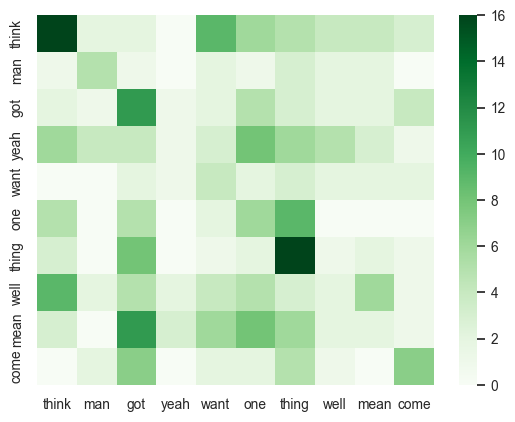

In [108]:
# Create a pivot table of word frequencies
word_freq = Rick_mont['text_lemmatized'].str.split(expand=True).stack().value_counts()

# Create a co-occurrence matrix of the top 100 words
top_words = word_freq.head(10).index.tolist()
co_matrix = pd.DataFrame(0, index=top_words, columns=top_words)
for dialogue in Rick_mont['text_lemmatized']:
    words = [word for word in dialogue.lower().split() if word in top_words]
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            co_matrix.at[words[i], words[j]] += 1

# Create the heatmap
sns.set(font_scale=0.9)
sns.heatmap(co_matrix, cmap="Greens")


### The Bigram

* #### Most frequent combinations

In [109]:
# Create bigrams
Rick_mont["Bigrams"] = Rick_mont["Tokenize"].apply(lambda x: list(bigrams(x)))
scripts = Rick_mont.explode("Bigrams")

# Count bigrams frequency
bigram_counts = scripts["Bigrams"].value_counts().reset_index()
bigram_counts.columns = ["Bigram", "Freq"]
bigram_counts = bigram_counts[bigram_counts["Freq"] >= 5]
bigram_counts


,Bigram,Freq
0,"(can, not)",35
1,"(whoa, whoa)",22
2,"(got, ta)",16
3,"(let, u)",13
4,"(holy, crap)",10
5,"(aw, geez)",9
6,"(wan, na)",9
7,"(mr, president)",7
8,"(rick, mortys)",7
9,"(mr, pancake)",7


### Bigram Network

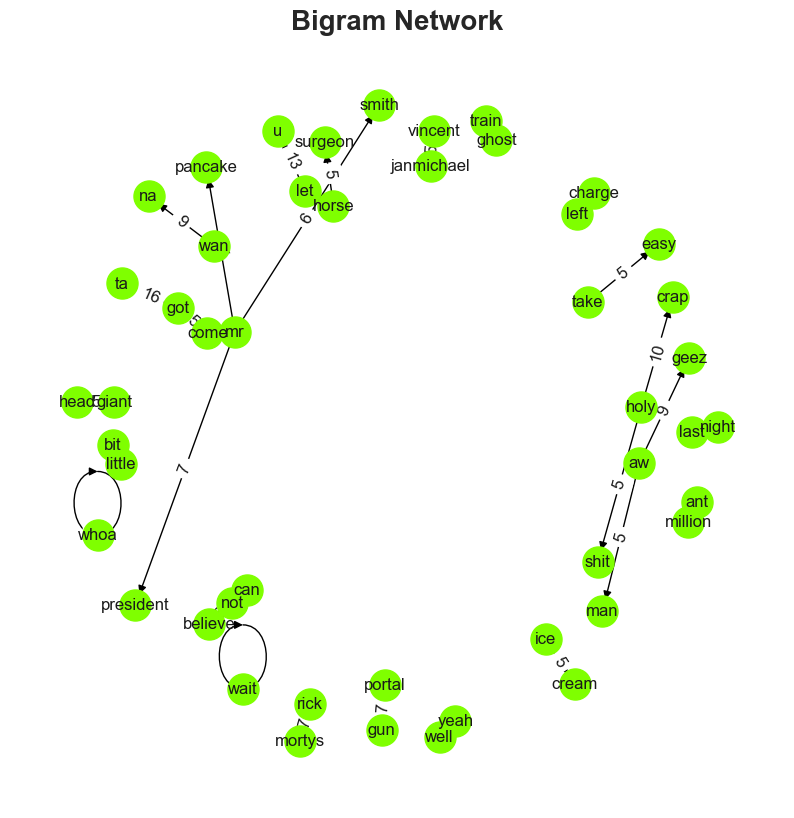

In [110]:
# Create nodes
nodes = set([word for bigram in bigram_counts["Bigram"] for word in bigram])

# Create edges
edges = [(bigram[0], bigram[1], freq) for bigram, freq in zip(bigram_counts["Bigram"], bigram_counts["Freq"])]

# Create graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

# Plot graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.3, seed=10)
nx.draw_networkx_nodes(G, pos, node_color="#7FFF00", node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="black", arrows=True, arrowsize=12, width=1)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w}" for (u, v, w) in G.edges(data='weight')}, font_size=12)
plt.title("Bigram Network", fontsize=20, fontweight='bold')
plt.axis("off")
plt.show()
